In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import random_split, DataLoader, Subset
from torchvision.models import resnet18
from sklearn.linear_model import LogisticRegression
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from torchvision.datasets import Food101
from torchvision.models import resnext50_32x4d

In [6]:
device = 'cpu' # torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

print(f"Using device: {device}")


Using device: cpu


### Loading the data

In [7]:
# transform = transforms.Compose([
#     transforms.Resize(224),  
#     transforms.ToTensor(),
# ])


# full_cifar100 = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
# testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

# subset_indices = list(range(50000))
# reduced_train = Subset(full_cifar100, subset_indices)

# calib_size = 5000  
# train_size = len(reduced_train) - calib_size

# trainset, calibset = random_split(reduced_train, [train_size, calib_size])

# train_loader = DataLoader(trainset, batch_size=64, shuffle=True)
# calib_loader = DataLoader(calibset, batch_size=64, shuffle=False)
# test_loader = DataLoader(testset, batch_size=64, shuffle=False)



# Define transforms (ResNet-friendly)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # For pretrained models
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# # Load the dataset (automatically downloads)
train_val_dataset = Food101(root="./data", split='train', transform=transform, download=False)
test_dataset = Food101(root="./data", split='test', transform=transform, download=False)

# Split train into train + calibration sets (e.g., 90% / 10%)
calib_size = int(0.1 * len(train_val_dataset))  # ~7.5k images
train_size = len(train_val_dataset) - calib_size
trainset, calibset = random_split(train_val_dataset, [train_size, calib_size])

# Create DataLoaders
train_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4)
calib_loader = DataLoader(calibset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)



### Training of the Model ResNet18/ 50

In [8]:


# model = resnet18(pretrained=True)
# model.fc = nn.Linear(model.fc.in_features, 101)  # Food101 has 101 classes
# model = model.to(device)

model = resnext50_32x4d(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 101)
model = model.to(device)

def train_model(model, train_loader, epochs=2):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    model.train()
    for epoch in range(epochs):
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

train_model(model, train_loader)


/home/nikhiljamuda/Desktop/RAPS/mvenv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nikhiljamuda/Desktop/RAPS/mvenv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/2:   0%|          | 1/1066 [00:20<6:04:41, 20.55s/it]


KeyboardInterrupt: 

In [ ]:

def get_logits(model, dataloader, device):
    model.eval()
    logits_list, labels_list = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)  
            logits_list.append(outputs.cpu())
            labels_list.append(labels)

    return torch.cat(logits_list), torch.cat(labels_list)

def platt_scaling(logits, labels):
    clf = LogisticRegression(max_iter=1000)
    clf.fit(logits.numpy(), labels.numpy())

    def calibrated_probs_fn(x):
        return torch.tensor(clf.predict_proba(x.numpy()), dtype=torch.float32)

    return calibrated_probs_fn

def get_raps_scores(calib_probs, calib_labels, lambda_reg=0.1, k_reg=5):
    scores = []
    for j in range(len(calib_probs)):
        probs = calib_probs[j]
        sorted_probs, sorted_indices = torch.sort(probs, descending=True)
        true_class = calib_labels[j].item()
        k_prime = (sorted_indices == true_class).nonzero(as_tuple=True)[0].item() + 1

        ej = torch.sum(sorted_probs[:k_prime])
        if lambda_reg > 0:
            ej += lambda_reg * sum(i > k_reg for i in range(k_prime))
        scores.append(ej.item())
    return np.array(scores)

def compute_threshold(scores, alpha=0.1):
    return np.quantile(scores, 1 - alpha, method="higher")

def raps_predict(probs, tau_cal, lambda_reg=0.1, k_reg=5):
    sorted_probs, sorted_indices = torch.sort(probs, descending=True)
    cumulative = 0.0
    prediction_set = []
    for i in range(len(sorted_probs)):
        cumulative += sorted_probs[i].item()
        if i > k_reg:
            cumulative += lambda_reg
        prediction_set.append(sorted_indices[i].item())
        if cumulative >= tau_cal:
            break
    return prediction_set



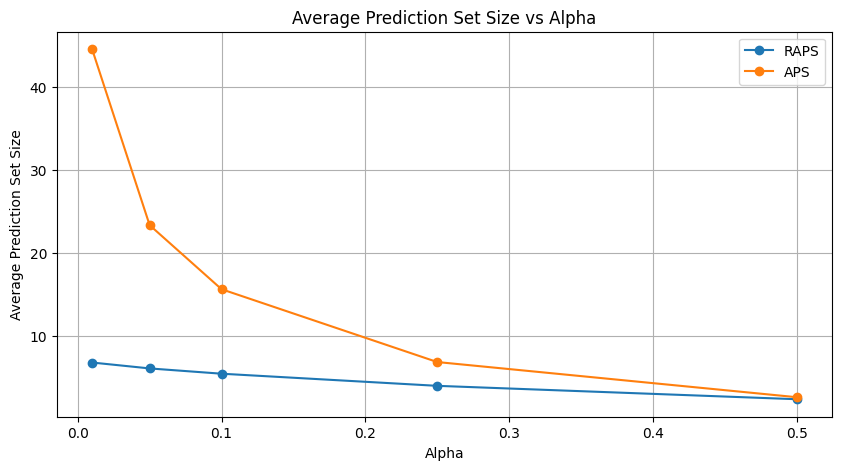

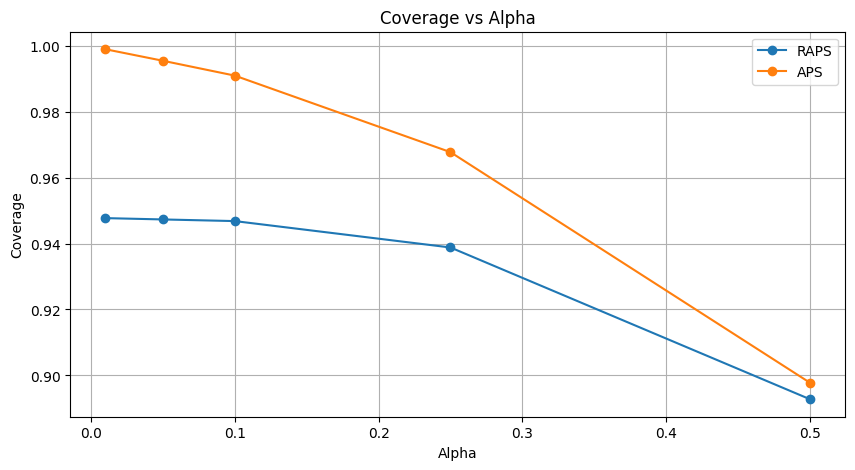

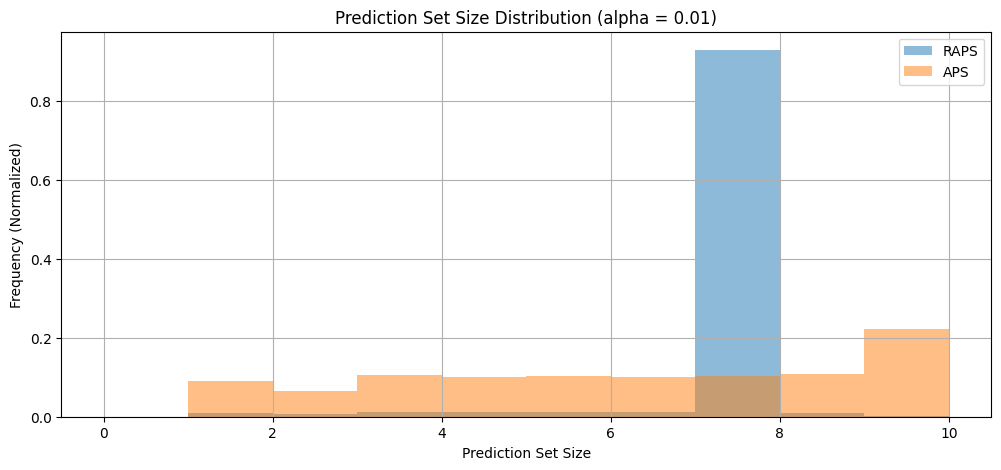

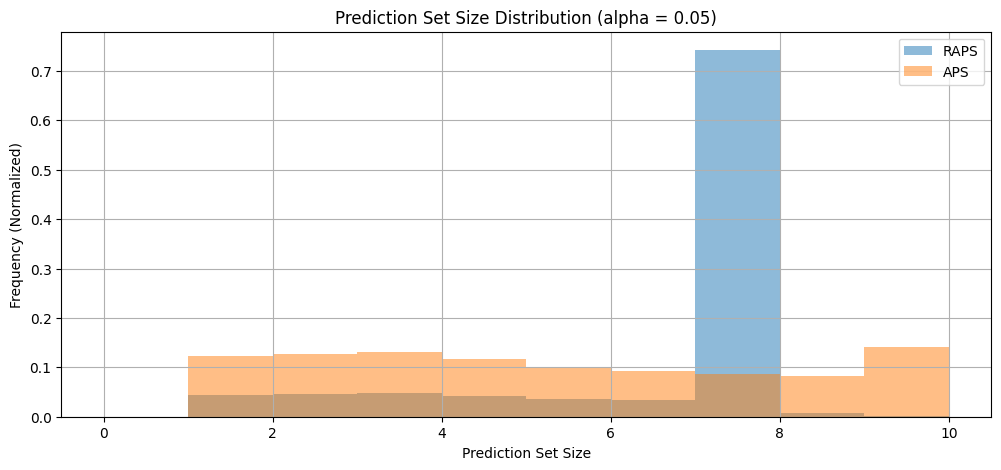

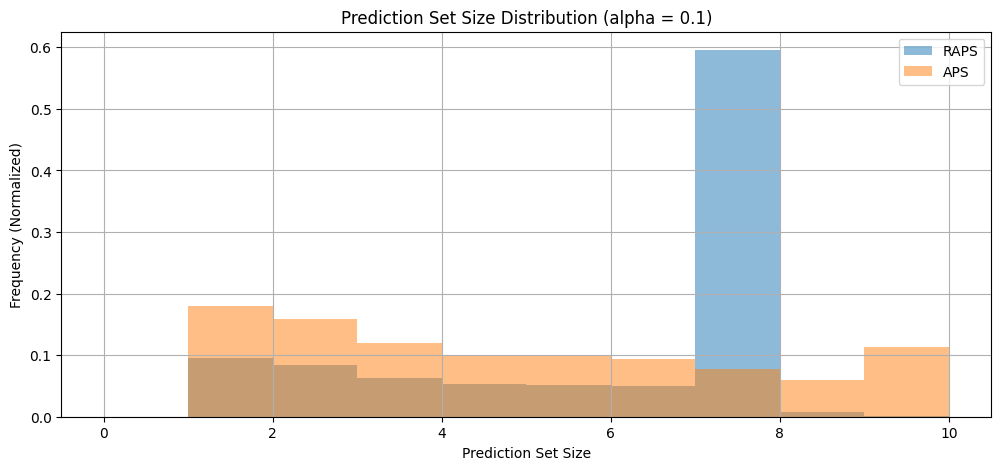

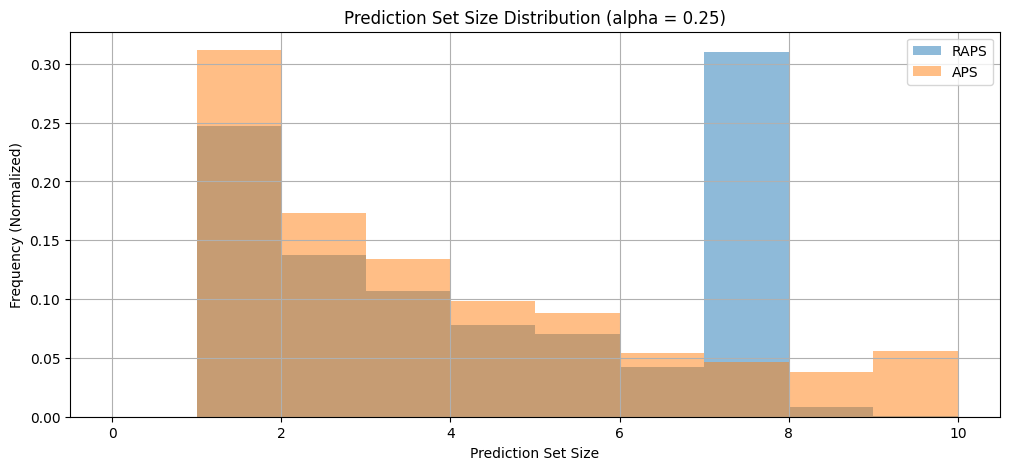

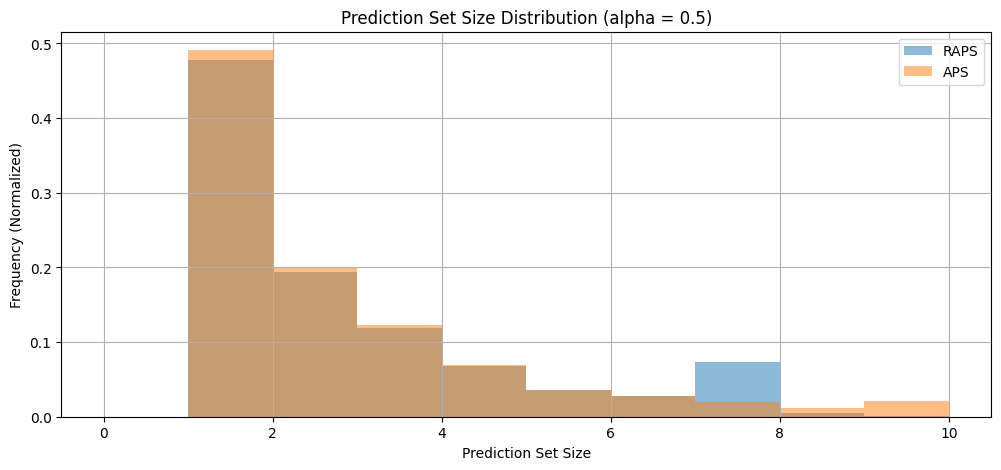

In [ ]:
logits_calib, labels_calib = get_logits(model, calib_loader, device)
calib_fn = platt_scaling(logits_calib, labels_calib)
calib_probs = calib_fn(logits_calib)


alphas = [0.01, 0.05, 0.1, 0.25, 0.5]
average_sizes = {'RAPS': [], 'APS': []}
average_coverages = {'RAPS': [], 'APS': []}
size_distributions = {'RAPS': {}, 'APS': {}}  

for alpha in alphas:

    # ------------------- Testing for RAPS ------------------- #
    scores = get_raps_scores(calib_probs, labels_calib, lambda_reg=0.1, k_reg=5)
    tau = compute_threshold(scores, alpha=alpha)
    logits_test, labels_test = get_logits(model, test_loader, device)
    test_probs = calib_fn(logits_test)
    prediction_sets = [raps_predict(probs, tau, lambda_reg=0.1, k_reg=5) for probs in test_probs]
    
    sizes = [len(pset) for pset in prediction_sets]
    avg_size = np.mean(sizes)
    coverage = np.mean([labels_test[i].item() in prediction_sets[i] for i in range(len(labels_test))])
    
    average_sizes['RAPS'].append(avg_size)
    average_coverages['RAPS'].append(coverage)
    size_distributions['RAPS'][alpha] = sizes

    # ------------------- Testing for APS ------------------- #
    scores2 = get_raps_scores(calib_probs, labels_calib, lambda_reg=0, k_reg=0.2)
    tau2 = compute_threshold(scores2, alpha=alpha)
    prediction_sets = [raps_predict(probs, tau2, lambda_reg=0, k_reg=5) for probs in test_probs]

    sizes2 = [len(pset) for pset in prediction_sets]
    avg_size2 = np.mean(sizes2)
    coverage2 = np.mean([labels_test[i].item() in prediction_sets[i] for i in range(len(labels_test))])

    average_sizes['APS'].append(avg_size2)
    average_coverages['APS'].append(coverage2)
    size_distributions['APS'][alpha] = sizes2


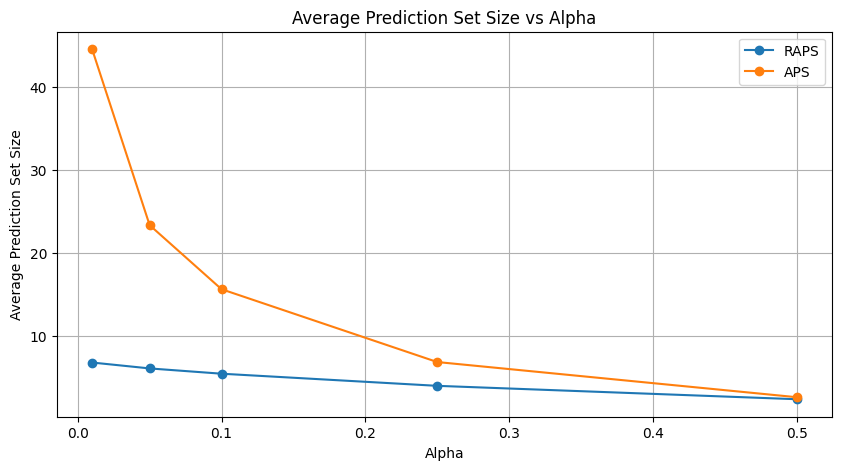

In [ ]:

# ------------------- Plotting Average Prediction Set Size ------------------- #
plt.figure(figsize=(10, 5))
plt.plot(alphas, average_sizes['RAPS'], label='RAPS', marker='o')
plt.plot(alphas, average_sizes['APS'], label='APS', marker='o')
plt.xlabel('Alpha')
plt.ylabel('Average Prediction Set Size')
plt.title('Average Prediction Set Size vs Alpha')
plt.legend()
plt.grid()
plt.savefig('average_prediction_set_size.png')
plt.show()


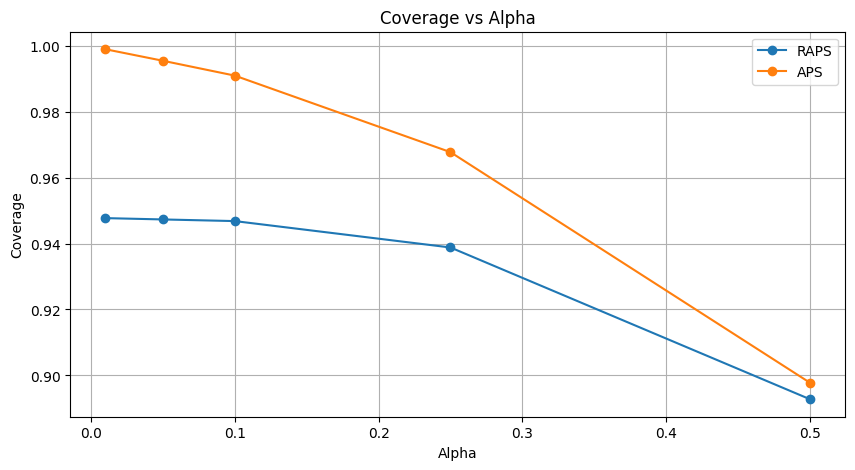

In [ ]:

# ------------------- Plotting Coverage ------------------- #
plt.figure(figsize=(10, 5))
plt.plot(alphas, average_coverages['RAPS'], label='RAPS', marker='o')
plt.plot(alphas, average_coverages['APS'], label='APS', marker='o')
plt.xlabel('Alpha')
plt.ylabel('Coverage')
plt.title('Coverage vs Alpha')
plt.legend()
plt.grid()
plt.savefig('coverage.png')
plt.show()


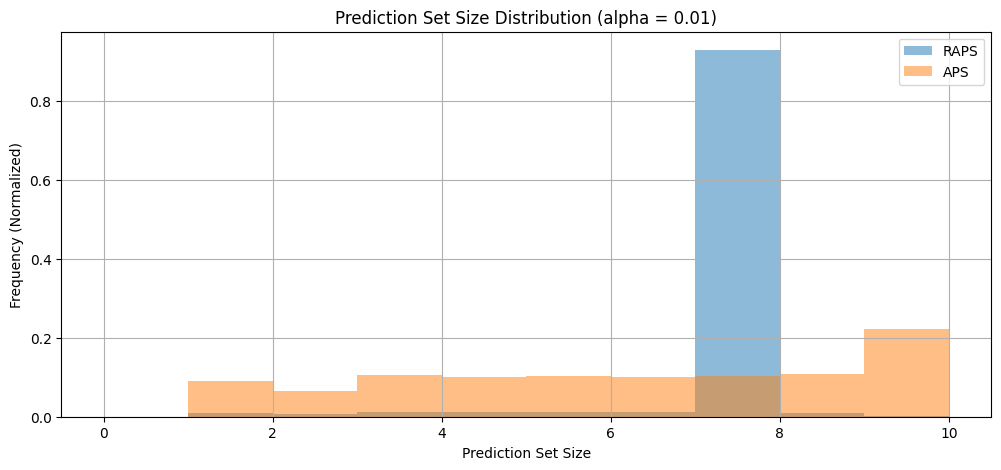

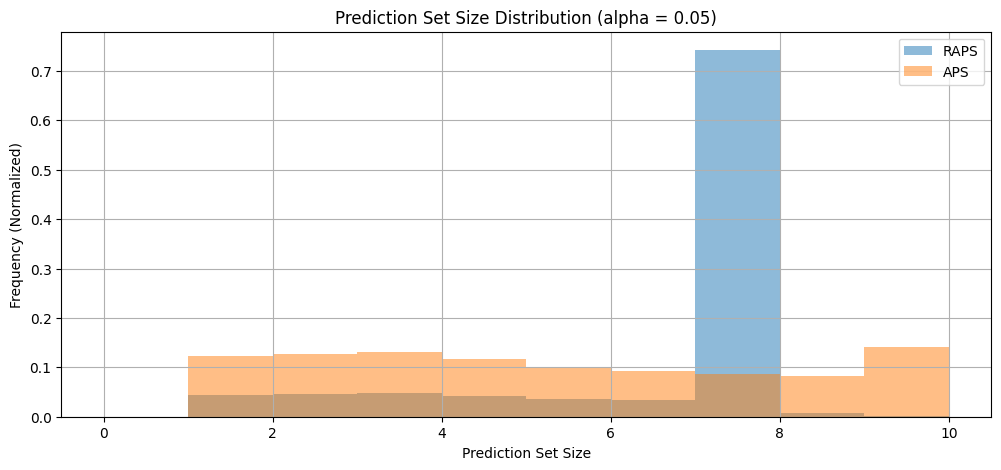

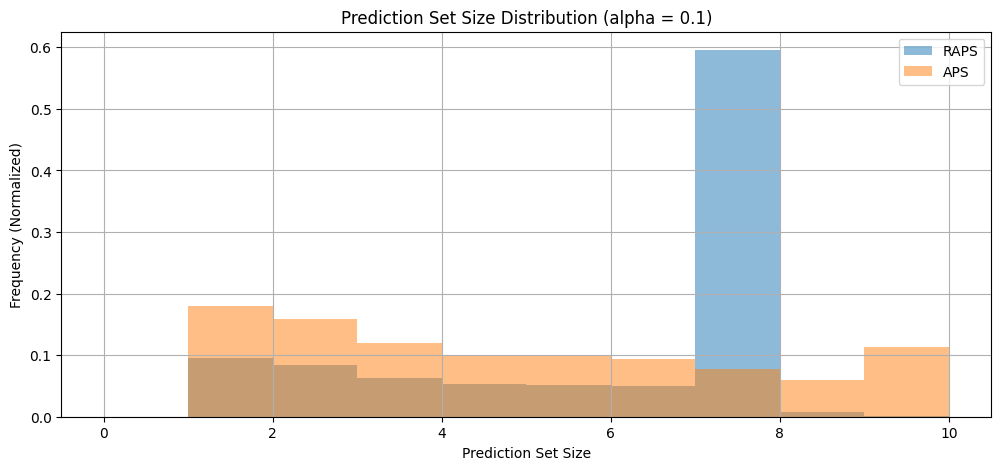

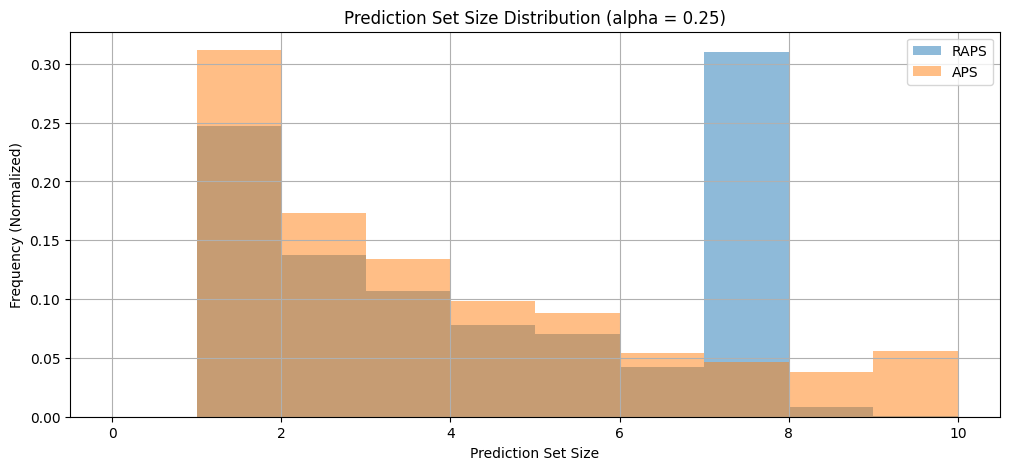

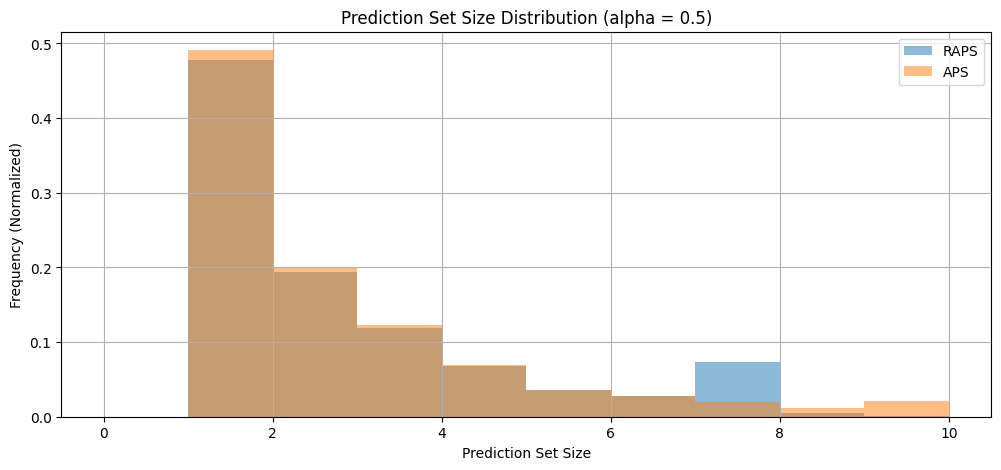

In [13]:

# ------------------- Histograms of Prediction Set Sizes ------------------- #
for alpha in alphas:
    plt.figure(figsize=(12, 5))
    plt.hist(size_distributions['RAPS'][alpha], bins=range(0, 11), alpha=0.5, label='RAPS', density=True)
    plt.hist(size_distributions['APS'][alpha], bins=range(0, 11), alpha=0.5, label='APS', density=True)
    plt.xlabel('Prediction Set Size')
    plt.ylabel('Frequency (Normalized)')
    plt.title(f'Prediction Set Size Distribution (alpha = {alpha})')
    plt.legend()
    plt.grid()
    plt.savefig(f'prediction_set_size_distribution_alpha_{alpha}.png')
    plt.show()
